In [1]:
import sys
sys.path.append("/Users/fabio/jars")
import pandas as pd
import numpy as np
import tqdm
from pyspark.sql.window import Window
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from graphframes import GraphFrame
from pyspark.sql.types import *
import multiprocessing
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os
import shutil

In [2]:
spark_driver_memory = "10g"
spark_executor_memory = "6g"
spark_partial_results_folder = './partial_results'


spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.executor.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .config("spark.sql.autoBroadcastJoinThreshold", 100 * 1024 * 1024)\
                    .config("spark.driver.port", 4040) \
                    .config("spark.driver.bindAddress", "127.0.0.1") \
                    .getOrCreate()
print("Spark session created")
sc = spark.sparkContext
print("Spark context created")


if not os.path.exists(spark_partial_results_folder):
    os.makedirs(spark_partial_results_folder)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/23 16:06:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created
Spark context created


## Load data

In [3]:
# Definizione dello schema per la lettura del file 
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', StringType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', StringType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', StringType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', StringType(), True),
    StructField('payment_format', StringType(), True),
    StructField('is_laundering', IntegerType(), True)])

#Lettura del file csv direttamente in spark
df = spark.read.csv("../dataset/HI-Small_Trans.csv", header = False, schema=schema)

#Rimozione della prima riga in quanto è presente l'header del csv
df = df.filter(col('timestamp') != "Timestamp")

#Aggiunta dell'id univoco per le righe.
df = df.withColumn("index", monotonically_increasing_id())

df.show(5, truncate=False)
df.printSchema()


+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|timestamp       |from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|2022/09/01 00:20|10       |8000EBD30   |10     |8000EBD30 |3697.34        |US Dollar         |3697.34    |US Dollar       |Reinvestment  |0            |0    |
|2022/09/01 00:20|3208     |8000F4580   |1      |8000F5340 |0.01           |US Dollar         |0.01       |US Dollar       |Cheque        |0            |1    |
|2022/09/01 00:00|3209     |8000F4670   |3209   |8000F4670 |14675.57       |US Dollar         |14675.57   |US Dollar       |Reinvestment  |0            |2    |
|2022/09/01 00:02|12       |8000F5030   

L'analisi sui dati verrà suddivisa in più parti: 
Inizialmente verrà fatta un'analisi indipendente dall'ordine temporale, che si concentrerà principalmente sul capire la struttura del dataset, le proporzioni tra laundering e non laundering e se ci sono marcate differenze tra le features delle due classi. 
Successivamente si andrà ad esplorare meglio la relazione temporale tra i dati essendo il tempo una delle feature principali quando si cerca di scovare pattern fraudolenti.
Infine, calcolate le features che si pensa possano essere di interesse, verrà calcolata la matrice di correlazione per capire quanto siano correlate le features all'interno del dataset per capirne anche l'importanza ai fini dell'apprendimento del modello.

## Prime analisi sul dataset

In questa sezione andremo a vedere come sono distribuite le classi all'interno del dataset, andando a studiare anche la proporzione di transazioni fraudolente per le diverse tipologie di metodi di pagamento e di formato, oltre alla differenza, se presente, tra amount che vengono spostati quando le transazioni sono fraudolente.

In [4]:
# Controllo se ci sono valori nulli in qualche cella
df.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|        0|        0|           0|      0|         0|              0|                 0|          0|               0|             0|            0|    0|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+



Non sono presenti valori nulli, quindi non è necessario rimuovere o modificare alcuna riga. Dunque si può procedere con le successive analisi

In [5]:
#Proporzione tra laundering e non laundering all'interno del dataset. 1: Laundering, 0: Not laundering
total_count = df.count()
df.select('is_laundering').groupBy('is_laundering').agg(count('*').alias('count')).withColumn("proportion", col('count')/total_count).show(5, truncate=False)

+-------------+-------+---------------------+
|is_laundering|count  |proportion           |
+-------------+-------+---------------------+
|1            |5177   |0.0010194266045335635|
|0            |5073168|0.9989805733954664   |
+-------------+-------+---------------------+



Fin da subito è possibile osservare che le transazioni fraudolente sono all'incirca 1/1000 di quelle totali. Questo porta ad avere un dataset altamente sbilanciato e rende l'identificazione di pattern più complessa.

### Display payment format in relation to laundering transaction

+--------------+----+-------+----------+
|payment_format|1   |0      |proportion|
+--------------+----+-------+----------+
|ACH           |4483|596314 |0.007518  |
|Bitcoin       |56  |146035 |0.000383  |
|Cash          |108 |490783 |0.000220  |
|Cheque        |324 |1864007|0.000174  |
|Credit Card   |206 |1323118|0.000156  |
|Reinvestment  |0   |481056 |0.000000  |
|Wire          |0   |171855 |0.000000  |
+--------------+----+-------+----------+



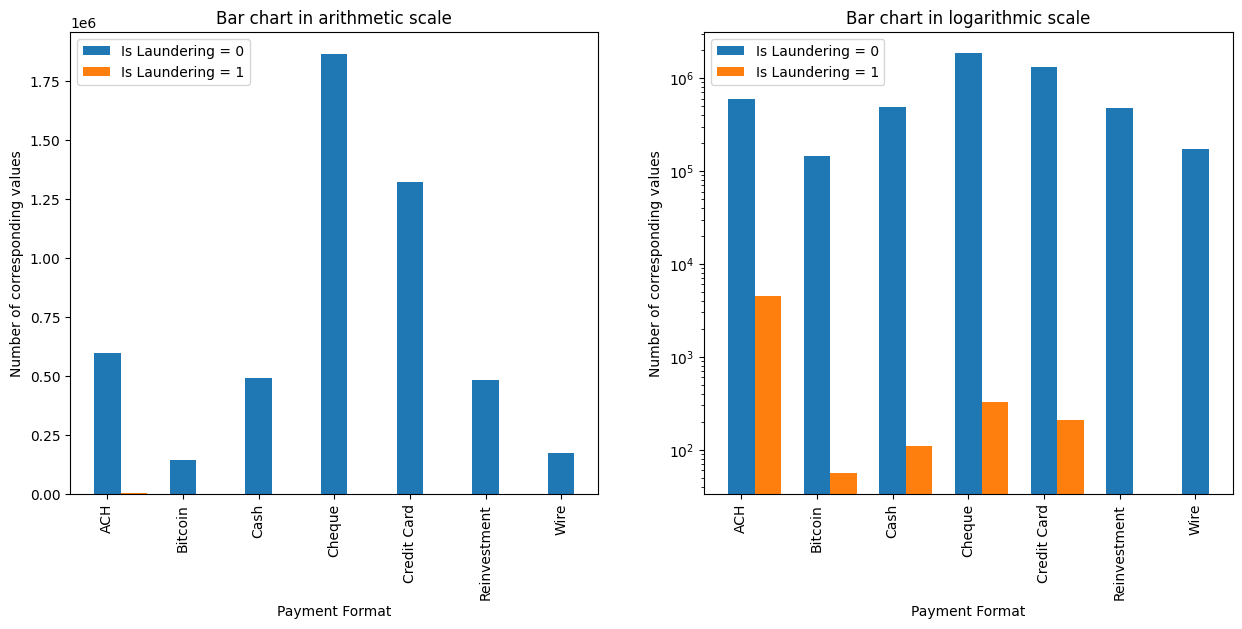

In [6]:
df.select('payment_format', 'is_laundering') \
    .groupBy('payment_format') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ) \
    .withColumn("proportion", (col("1") / col("0")).cast('Decimal(20,6)')) \
    .orderBy('proportion', ascending=False) \
    .show(truncate=False)

# Calculate the number of corresponding values for each value of the "Payment Format" and "Is Laundering" columns
grouped_df = df.groupBy("payment_format", "is_laundering").count()

count_values = grouped_df.toPandas()
count_values_payment = count_values.pivot(index='payment_format', columns='is_laundering', values='count')


fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_payment.index))

#Arithmetic scale
axs[0].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[0].set_xlabel('Payment Format')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

#Logaritmic scale
axs[1].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[1].set_xlabel('Payment Format')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()

L'analisi sul formato di pagamento in relazione alle transazioni laundering mostra in maniera abbastanza evidente che la metodologia di pagamento ACH è molto spesso correlata ad una transazione fraudolenta, mentre, ancor più interessante, le metodologie Reinvestment e Wire non contengono alcun tipo di transazione fraudolenta. Questo fa intuire fin da subito che il formato di pagamento è una feature essenziale da tenere in considerazione, in quanto già da sola, se usata con un modello ad albero, dovrebbe essere in grado di classificare correttamente tutte le transazioni Reinvestment e Wire.

### Display payment currency in relation to laundering transaction

+-----------------+----+-------+----------+
|payment_currency |1   |0      |proportion|
+-----------------+----+-------+----------+
|Saudi Riyal      |374 |88640  |0.004219  |
|Euro             |1372|1166925|0.001176  |
|US Dollar        |1912|1893260|0.001010  |
|Yen              |155 |155054 |0.001000  |
|Australian Dollar|127 |136642 |0.000929  |
|Canadian Dollar  |128 |139914 |0.000915  |
|Rupee            |167 |190035 |0.000879  |
|Yuan             |184 |213568 |0.000862  |
|Ruble            |133 |155045 |0.000858  |
|Mexican Peso     |92  |110067 |0.000836  |
|Swiss Franc      |193 |234667 |0.000822  |
|Brazil Real      |57  |70646  |0.000807  |
|UK Pound         |132 |180606 |0.000731  |
|Shekel           |95  |192089 |0.000495  |
|Bitcoin          |56  |146010 |0.000384  |
+-----------------+----+-------+----------+



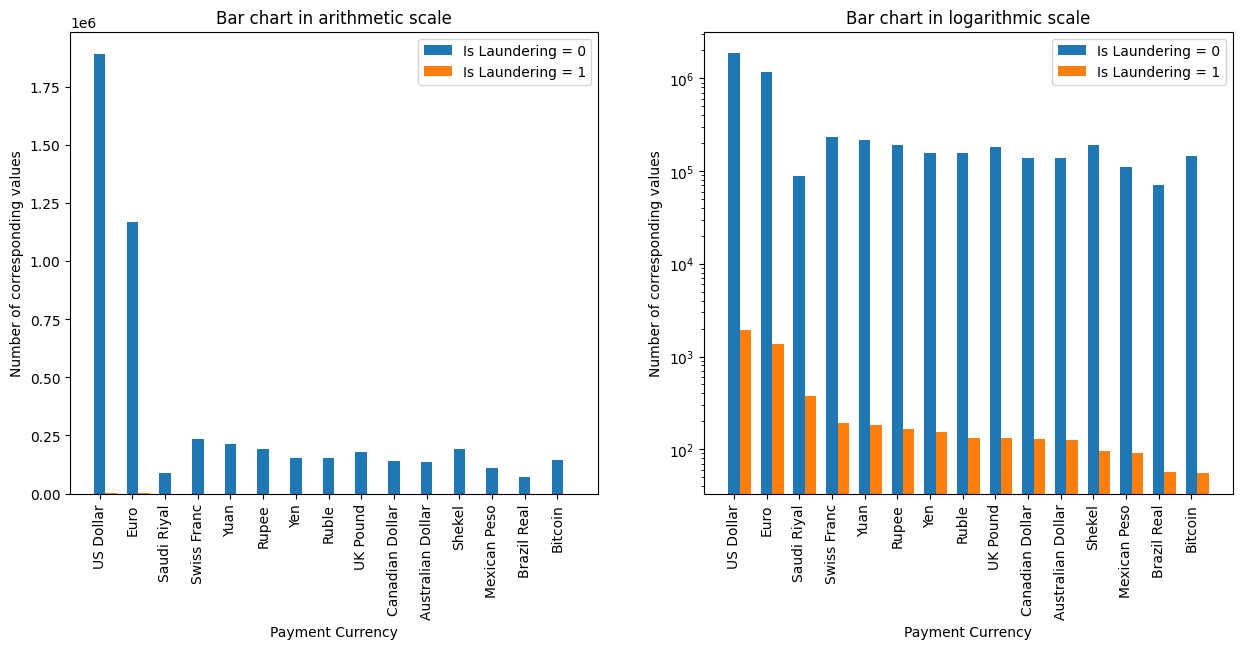

In [7]:
df.select('payment_currency', 'is_laundering') \
    .groupBy('payment_currency') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ) \
    .withColumn("proportion", (col("1") / col("0")).cast('Decimal(20,6)')) \
    .orderBy('proportion', ascending=False) \
    .show(truncate=False)

grouped_df = df.groupBy("payment_currency", "is_laundering").count()

# Convert Spark DataFrame to Pandas DataFrame
count_values = grouped_df.toPandas()

# Use the unstack() method
count_values_currency = count_values.pivot(index='payment_currency', columns='is_laundering', values='count')

# Sort the values by Is Laundering = 1 in descending order
count_values_currency = count_values_currency.sort_values(1, ascending=False)

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_currency.index))
axs[0].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_currency.index, rotation='vertical') 
axs[0].set_xticklabels(count_values_currency.index)
axs[0].set_xlabel('Payment Currency')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_currency.index, rotation='vertical') 
axs[1].set_xticklabels(count_values_currency.index)
axs[1].set_xlabel('Payment Currency')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()

Lo studio sulle metodologie di pagamento in relazione alle transazioni fraudolente risulta essere meno incisivo di quello sul formato di pagamento. In ogni caso dimostra come la tipologia di pagamento US Dollar, che sembra essere anche la più frequente all'interno del dataset, contiene il maggior numero di transazioni fraudolente. Nonostante questo, a livello di proporzione, sembra essere molto più fraudolento il metodo di pagamento Saudi Riyal, seguito da Euro. Questa features risulta comunque utile in quanto permette di aumentare la probabilità di classificare correttamente una transazione fraundolenta.

### Display relationhip between amount paid and laundering transaction

+-------------+--------+-------------+-------------------+
|is_laundering|     min|          max|               mean|
+-------------+--------+-------------+-------------------+
|            1|0.003227| 8.4853146E10|3.613531071586281E7|
|            0|0.000001|1.04630236E12|  4477000.057857962|
+-------------+--------+-------------+-------------------+



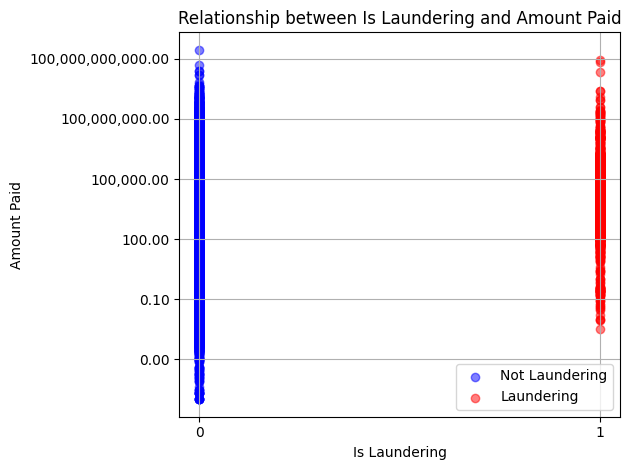

In [8]:
grouped_stats = df.groupBy('is_laundering').agg(
    min(col('amount_paid')).alias('min').cast('Decimal(20,6)').alias('min'),
    max(col('amount_paid')).alias('max').alias('max'),
    mean(col('amount_paid')).alias('mean').alias('mean')
)

grouped_stats.show()

# Sottocampiona la classe maggioritaria
df_0 = df.filter(df['is_laundering'] == 0).sample(withReplacement=False, fraction=100000/5000000)
df_1 = df.filter(df['is_laundering'] == 1)
df_sampled = df_0.union(df_1)


df_pd = df_sampled.toPandas()

plt.yscale("log")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, ',.2f')))

# Plotta i punti per is_laundering == 0 in blu e is_laundering == 1 in rosso
plt.scatter(df_pd[df_pd['is_laundering'] == 0]['is_laundering'], df_pd[df_pd['is_laundering'] == 0]['amount_paid'], color='blue', alpha=0.5, label='Not Laundering')
plt.scatter(df_pd[df_pd['is_laundering'] == 1]['is_laundering'], df_pd[df_pd['is_laundering'] == 1]['amount_paid'], color='red', alpha=0.5, label='Laundering')

plt.title("Relationship between Is Laundering and Amount Paid")
plt.xlabel("Is Laundering")
plt.ylabel("Amount Paid")
plt.xticks([0, 1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A differenza delle precedenti analisi, andando a studiare il comportamento che hanno le transazioni fraudolente rispetto all'ammontare della somma inviata, si nota come non ci sia alcun tipo di separazione tra transazione fraudolenta o non fraudolenta. Infatti, utilizzando un grafico, è possibile notare come il range di amount delle transazioni fraudolenti è contenuto all'interno di quelle non fraudolenti senza un effettivo stacco. Oltretutto, considerando che le transazioni fraudolenti sono circa 1/1000 di quelle non fraudolenti, si può evincere che molto probabilmente l'amount della transazione sporca e non aiuta la capacità del modello a classificare correttamente i dati. 

Le due features verranno comunque mantenute per osservarle meglio nella matrice di correlazione.

### Display top 10 accounts for fraudolent transactions

In [9]:
# Calcola il numero totale di transazioni per ogni account
total_transactions = df.groupBy('from_account')\
    .agg(F.count('*').alias('total_trans'))

# Conta il numero di transazioni fraudolente per ogni account
fraudulent_transactions = df.filter(col('is_laundering') == 1)\
    .groupBy('from_account')\
    .agg(F.count('*').alias('count_laundering'))

# Unisci i due conteggi
joined_df = total_transactions.join(fraudulent_transactions, 'from_account', 'left_outer')\
    .fillna(0)  # In caso non ci siano transazioni fraudolente per un determinato account

# Calcola il rapporto
joined_df = joined_df.withColumn('fraud_rate', (F.col('count_laundering') / F.col('total_trans')).cast('Decimal(20,6)'))

# Ordina e mostra i risultati
joined_df.orderBy('total_trans', ascending=False).show(10)
print(f"Number of account that send just one transaction and it is fraudolent: {joined_df.filter((col('total_trans') == 1) & (col('fraud_rate') == 1)).count()}")

+------------+-----------+----------------+----------+
|from_account|total_trans|count_laundering|fraud_rate|
+------------+-----------+----------------+----------+
|   100428660|     168672|             243|  0.001441|
|   1004286A8|     103018|             158|  0.001534|
|   100428978|      20497|              29|  0.001415|
|   1004286F0|      18663|              21|  0.001125|
|   100428780|      17264|              21|  0.001216|
|   1004289C0|      16794|              13|  0.000774|
|   100428810|      16426|              26|  0.001583|
|   1004287C8|      14174|              16|  0.001129|
|   100428738|      13756|              23|  0.001672|
|   100428A51|      13073|              18|  0.001377|
+------------+-----------+----------------+----------+
only showing top 10 rows



Number of account that send just one transaction and it is fraudolent: 122


### Find how many times an account send laundering and not laundering transaction to same account

In [10]:
df_temp = df.select('from_account', 'to_account', 'is_laundering')

# Raggruppa e conta le occorrenze uniche
grouped_df = df_temp.groupBy('from_account', 'to_account').agg(collect_set('is_laundering').alias('unique_values'))

# Filtra i risultati con più di una occorrenza
filtered_df = grouped_df.filter(col('unique_values').getItem(0) != col('unique_values').getItem(1))

# Calcola il numero di occorrenze filtrate per ogni 'from_account'
result_df = filtered_df.groupBy('from_account').count().orderBy(col('count').desc())

# Mostra i primi 10 risultati
result_df.show(10)

+------------+-----+
|from_account|count|
+------------+-----+
|   100428660|  236|
|   1004286A8|  156|
|   100428978|   28|
|   100428810|   26|
|   100428738|   22|
|   1004286F0|   21|
|   100428780|   21|
|   100428A51|   18|
|   1004288A0|   16|
|   1004287C8|   16|
+------------+-----+
only showing top 10 rows



Per quanto riguarda gli account si evince come ci siano account che hanno effettuato nettamente più transazioni di altri. A parte questo, l'utilizzo degli accoun come features non è rilevante ai fini dell'allenamento del modello. Possiamo però andare a studiare il comportamento delle transazioni quando gli account sono uguali o diversi e capire se c'è una particolare correlazione con transazioni fraudolente. Stesso può essere fatto con la valuta di partenza e di arrivo e con l'amount di partenza e di arrivo.

### Show relationship between same account and fraudolent transaction

In [11]:
# Filtra le righe e raggruppa per is_laundering
grouped_df = df.filter(F.col('from_account') == F.col('to_account'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+------+----------+
|is_laundering| count|proportion|
+-------------+------+----------+
|            1|    11|  0.002125|
|            0|591201|  0.116535|
+-------------+------+----------+



Da queste analisi risulta molto poco probabile che una transazione che contenga lo stesso account di partenza e di destinazione sia fraudolenta. Questa potrebbe rilevarsi una features interessante da considerare e aggiungere.

In [12]:
def add_same_account(df):
    return df.withColumn('same_account', when((col('from_account') == col('to_account')), 1).otherwise(0))

In [13]:
# Aggiunta della feature che considera se l'account di partenza e destinazione sono uguali
df = add_same_account(df)

### Show relationship between same bank and fraudolent transaction

In [14]:
# Filtra le righe e raggruppa per is_laundering
grouped_df = df.filter(F.col('from_bank') == F.col('to_bank'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+------+----------+
|is_laundering| count|proportion|
+-------------+------+----------+
|            1|   103|  0.019896|
|            0|691229|  0.136252|
+-------------+------+----------+



In [15]:
from_df = df.select(col("from_account").alias("account"), col("from_bank").alias("bank"))
to_df = df.select(col("to_account").alias("account"), col("to_bank").alias("bank"))
combined_df = from_df.union(to_df)

# Raggruppa per account e conta le banche distinte
result_df = combined_df.groupBy("account").agg(countDistinct("bank").alias("num_banks"))

# Filtra gli account con più di una banca associata
filtered_df = result_df.filter(result_df["num_banks"] > 1)

show_df = filtered_df.orderBy('num_banks', ascending=False)
print(f'Number of account with more than one bank associated: {show_df.count()}')
# 4. Mostra i risultati
show_df.show()

Number of account with more than one bank associated: 8


+---------+---------+
|  account|num_banks|
+---------+---------+
|80FA55EF0|        2|
|8135B8200|        2|
|81211BC00|        2|
|80FA56340|        2|
|8135B8250|        2|
|80A7FD400|        2|
|81211BA20|        2|
|80A7FDE00|        2|
+---------+---------+



Lo studio dimostra che ci sono 8 account che hanno più di una banca associata e che il massimo di banche associate è 2. Inoltre dimostra che c'è una più forte correlazione tra la banca di invio e ricezione uguale rispetto allo stesso account. Ovviamente una stessa banca può appartenere a più utenti. E' anche questa una feature che potrebbe tornare utile nella classificazione.

In [16]:
def add_same_bank(df):
    return df.withColumn('same_bank', when((col('from_bank') == col('to_bank')), 1).otherwise(0))

In [17]:
# Aggiunta della feature che considera se l'account di partenza e destinazione sono uguali
df = add_same_bank(df)

### Show relationship between same amount and fraudolent transaction

In [18]:
# Filtra le righe e raggruppa per is_laundering
grouped_df = df.filter(F.col('amount_received') == F.col('amount_paid'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+-------+----------+
|is_laundering|  count|proportion|
+-------------+-------+----------+
|            1|   5177|  1.000000|
|            0|5001010|  0.985777|
+-------------+-------+----------+



In questo caso possiamo vedere che tutte le transazioni che sono fraudolente hanno l'amount inviato e ricevuto uguale. Di conseguenza possiamo dedurre che abbiano anche la stessa valuta di invio e ricezione, in quanto sennò ci sarebbe una differenza dovuta al cambio valuta. In ogni caso, seppur questa possa sembrare una feature interessante, mettendola in relazione anche con le transazioni non fraudolente, risulta che non c'è molta differenza. In poche parole, qualora amount received e send non fossero uguali, la classificazione sarebbe corretta. C'è però da considerare che solo l'1,5% del dataset presenta questa caratteristica, dunque potrebbe non essere così impattante. 

Effettuiamo comunque un'analisi per vedere anche se ci sono casi in cui l'amount è diverso nonostante le currencies siano uguali

### Show relationship between same currency and fraudolent transaction

In [19]:
# Filtra le righe e raggruppa per is_laundering
grouped_df = df.filter(F.col('receiving_currency') == F.col('payment_currency'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+-------+----------+
|is_laundering|  count|proportion|
+-------------+-------+----------+
|            1|   5177|  1.000000|
|            0|5000998|  0.985774|
+-------------+-------+----------+



Questa analisi dimostra che non c'è una correlazione 1:1 tra amount e currency in quanto si evince che ci siano transazioni che non hanno la stessa valuta di invio e ricezione ma hanno lo stesso amount. La differenza è però trascurabile. In ogni caso, considerando che anche questo studio ha portato a dimostrare che tutte le transazioni fraudolente hanno la stessa valuta, ma meno transazioni non fraudolente hanno la stessa valuta, andiamo a considerare solo 'same_amount' come feature da aggiungere in quanto, seppur di poco, ci offre uno stacco maggiore di proporzione rispetto ai laundering.

Rimane comunque che questa feature non porta ad una separazione delle classi considerevole e dunque in un processo di feature selection potrebbe venir scartata.

In [20]:
def add_same_currency(df):
    return df.withColumn('same_currency', when((col('receiving_currency') == col('payment_currency')), 1).otherwise(0))

In [21]:
# Aggiunta della feature che considera se la valuta di partenza e destinazione sono uguali
df = add_same_currency(df)

## Analisi considerando il timestamp

Come prima cosa è necessario andare a fare un casting del timestamp da stringa a DateType. Oltre a questo vado a separare il timestamp in componenti separate così da poterlo analizzare più facilmente.

In [22]:
df = df.withColumn("timestamp", to_timestamp("timestamp", "yyyy/MM/dd HH:mm"))

# Split the timestamp column into separate components
df = df.withColumn("year", year("timestamp"))\
                             .withColumn("month", month("timestamp"))\
                             .withColumn("day", dayofmonth("timestamp"))\
                             .withColumn("hour", hour("timestamp"))\
                             .withColumn("minute", minute("timestamp"))


# Dato che ho fatto delle aggiunte di features, vado a fare il caching del dataset per migliorare le performance                
df.cache()
df.show(5)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+------------+---------+-------------+----+-----+---+----+------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|same_account|same_bank|same_currency|year|month|day|hour|minute|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+------------+---------+-------------+----+-----+---+----+------+
|2022-09-01 00:20:00|       10|   8000EBD30|     10| 8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|    0|           1|        1|            1|2022|    9|  1|   0|    20|
|2022-09-01 00:20:00|     3208|   8000F4580|      1| 8000F5340|           0.01|         US D

### Show laundering per componenti del timestamp

In [23]:
def laundering_for(df, col_name: str):
    print(f"Laundering for {col_name}")
    df.select(col_name, 'is_laundering') \
    .groupBy(col_name) \
    .agg(
        sum(col('is_laundering').cast('int')).alias('count(1)'),
        sum((1 - col('is_laundering')).cast('int')).alias('count(0)'),
    ).withColumn("ratio", (col('count(1)')/col('count(0)')).cast('Decimal(20,6)')) \
  .orderBy(col('ratio').desc()) \
  .show(truncate=False)

#### Laundering per Anno

In [24]:
laundering_for(df, 'year')

# Remove year feature
df = df.drop('year')

Laundering for year


+----+--------+--------+--------+
|year|count(1)|count(0)|ratio   |
+----+--------+--------+--------+
|2022|5177    |5073168 |0.001020|
+----+--------+--------+--------+



Il dataset presenta un solo anno di transazioni, quindi come feature 'year' risulta inutile. Per questo motivo andiamo a rimuoverla.

#### Laundering per Mese

In [25]:
laundering_for(df, 'month')

# Remove year feature
df = df.drop('month')

Laundering for month
+-----+--------+--------+--------+
|month|count(1)|count(0)|ratio   |
+-----+--------+--------+--------+
|9    |5177    |5073168 |0.001020|
+-----+--------+--------+--------+



Come per l'anno, anche 'month' ha un solo valore per tutte le righe. Procediamo dunque a rimuoverla.

#### Laundering per Giorno

In [26]:
laundering_for(df, 'day')

Laundering for day


+---+--------+--------+--------+
|day|count(1)|count(0)|ratio   |
+---+--------+--------+--------+
|18 |8       |3       |2.666667|
|17 |15      |8       |1.875000|
|15 |28      |18      |1.555556|
|12 |170     |111     |1.531532|
|11 |232     |164     |1.414634|
|14 |70      |51      |1.372549|
|13 |106     |78      |1.358974|
|16 |26      |20      |1.300000|
|10 |442     |207883  |0.002126|
|4  |407     |207023  |0.001966|
|3  |391     |206991  |0.001889|
|8  |539     |482234  |0.001118|
|6  |531     |481558  |0.001103|
|7  |497     |482254  |0.001031|
|5  |471     |482179  |0.000977|
|9  |514     |653953  |0.000786|
|2  |408     |754041  |0.000541|
|1  |322     |1114599 |0.000289|
+---+--------+--------+--------+



#### Laundering per hour

In [27]:
laundering_for(df, 'hour')

Laundering for hour
+----+--------+--------+--------+
|hour|count(1)|count(0)|ratio   |
+----+--------+--------+--------+
|12  |336     |192636  |0.001744|
|16  |311     |193096  |0.001611|
|11  |295     |193205  |0.001527|
|13  |292     |192229  |0.001519|
|14  |279     |192508  |0.001449|
|15  |263     |194608  |0.001351|
|8   |258     |192663  |0.001339|
|17  |257     |192897  |0.001332|
|18  |255     |193066  |0.001321|
|10  |234     |192995  |0.001212|
|19  |231     |192593  |0.001199|
|9   |217     |192735  |0.001126|
|6   |207     |194249  |0.001066|
|7   |195     |193141  |0.001010|
|5   |188     |193712  |0.000971|
|2   |165     |192978  |0.000855|
|21  |154     |192038  |0.000802|
|4   |154     |193012  |0.000798|
|1   |152     |193576  |0.000785|
|23  |150     |193195  |0.000776|
+----+--------+--------+--------+
only showing top 20 rows



#### Laundering for Minute

In [28]:
laundering_for(df, 'minute')

Laundering for minute
+------+--------+--------+--------+
|minute|count(1)|count(0)|ratio   |
+------+--------+--------+--------+
|44    |104     |76765   |0.001355|
|49    |98      |77188   |0.001270|
|33    |95      |76608   |0.001240|
|57    |93      |77737   |0.001196|
|53    |91      |77268   |0.001178|
|48    |91      |77232   |0.001178|
|32    |90      |76985   |0.001169|
|56    |90      |77096   |0.001167|
|31    |89      |76972   |0.001156|
|36    |89      |76983   |0.001156|
|55    |89      |77091   |0.001154|
|14    |106     |92078   |0.001151|
|43    |88      |76807   |0.001146|
|50    |88      |76891   |0.001144|
|39    |88      |77141   |0.001141|
|51    |86      |77080   |0.001116|
|11    |100     |90994   |0.001099|
|42    |84      |77000   |0.001091|
|16    |100     |91917   |0.001088|
|59    |84      |77380   |0.001086|
+------+--------+--------+--------+
only showing top 20 rows



A differenza del mese e dell'anno, i giorni, le ore e i minuti possono essere considerati come feature importanti. Si nota infatti come determinati valori sono più propensi ad essere fraudolenti rispetto ad altri. Andremo ad utilizzare queste tre nuove features per calcolarne di nuove in relazione agli account. 

### Count the number of transactions an account receive in different period of time

In [29]:
def add_trans_received(df):
    window = Window.partitionBy('to_account', 'day')
    df = df.withColumn("transaction_received_per_day", count('*').over(window))

    window = Window.partitionBy('to_account', 'hour')
    df = df.withColumn("transaction_received_per_hour", count('*').over(window))

    window = Window.partitionBy('to_account', 'minute')
    df = df.withColumn("transaction_received_per_minute", count('*').over(window))

    return df

In [30]:
df = add_trans_received(df)

### Count the number of transactions an account send in different period of time

In [31]:
def add_trans_send(df):
    window = Window.partitionBy('from_account', 'day')
    df = df.withColumn("transaction_send_per_day", count('*').over(window))

    window = Window.partitionBy('from_account', 'hour')
    df = df.withColumn("transaction_send_per_hour", count('*').over(window))

    window = Window.partitionBy('from_account', 'minute')
    df = df.withColumn("transaction_send_per_minute", count('*').over(window))

    return df

In [32]:
df = add_trans_send(df)

### Count the minutes since last transaction send by an Account

In [33]:
def add_minutes_since_last_trans(df):

    windowSpec = Window.partitionBy("from_account").orderBy("timestamp")

    # Usa la funzione 'lag' per ottenere il timestamp della transazione precedente
    df = df.withColumn("prev_timestamp", F.lag(df.timestamp).over(windowSpec))

    # Calcola la differenza in minuti
    df = df.withColumn(
        "minutes_since_last_transaction", 
        F.when(
            F.isnull(df.prev_timestamp), 
            -1
        ).otherwise(
            (F.unix_timestamp(df.timestamp) - F.unix_timestamp(df.prev_timestamp)) / 60
        )
    )

    # Seleziona le colonne desiderate
    return df.drop("prev_timestamp")

In [34]:
df = add_minutes_since_last_trans(df)

In [35]:
df.show(5)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+------+------------+---------+-------------+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering| index|same_account|same_bank|same_currency|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+------+-

### Count how many transactions are sent to unique accounts and bank in different period of time

In [36]:
def add_unique_to_bank_account(df):
    df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)


    #Day
    windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
                .rangeBetween(-1440, Window.currentRow)
    df = df.withColumn("unique_to_banks_last_day", F.size(F.collect_set("to_bank").over(windowSpec)))
    df = df.withColumn("unique_to_accounts_last_day", F.size(F.collect_set("to_account").over(windowSpec)))


    return df.drop('timestamp_minutes')



In [37]:
df = add_unique_to_bank_account(df)

### Count how many transactions are sent to unique accounts with same payment format in different period of time

In [38]:
def add_unique_payment_format(df):
    df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)
    
    #Day
    windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
                .rangeBetween(-1440, Window.currentRow)
    df = df.withColumn("unique_payment_formats_last_day", F.size(F.collect_set("payment_format").over(windowSpec)))

    return df.drop('timestamp_minutes')

In [39]:
df = add_unique_payment_format(df)

### Count how many transactions are sent to unique accounts with same payment currency in different period of time

In [40]:
def add_unique_payment_currency(df):
    df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)

    #Day
    windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
                .rangeBetween(-1440, Window.currentRow)
    df = df.withColumn("unique_payment_currency_last_day", F.size(F.collect_set("payment_currency").over(windowSpec)))

    return df.drop('timestamp_minutes')


In [41]:
df = add_unique_payment_currency(df)

### Count how many transactions an account execute to the same other account until the transaction itself

In [42]:
def add_transaction_recurrence(df):
    windowSpec = Window.partitionBy("from_account", "to_account").orderBy("timestamp").rowsBetween(Window.unboundedPreceding, Window.currentRow)
    return df.withColumn("transaction_recurrence", F.count("timestamp").over(windowSpec))

In [43]:
df = add_transaction_recurrence(df)

In [44]:
df.show(5)

23/08/23 15:56:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+------------+---------+-------------+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+------------------------+---------------------------+-------------------------------+--------------------------------+----------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|same_account|same_bank|same_currency|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|unique_to_bank

## Label encoding

Il label encoding viene fatto su tutte le features non numeriche così da poter successivamente creare la matrice di correlazione e utilizzare le features anche per allenare e testare il modello

In [45]:
def label_columns(df, col1, col2 = None):
    unique_columns = set(df.select(col1).orderBy(col1).distinct().rdd.flatMap(lambda x: x).collect())
    if(col2 != None):
        unique_columns.update(df.select(col2).distinct().rdd.flatMap(lambda x: x).collect())

    # Create a dictionary to map accounts to indexes
    column_to_index = {column: index for index, column in enumerate(unique_columns)}

    # Create a UDF to map accounts to their indexes
    from pyspark.sql.functions import udf
    from pyspark.sql.types import IntegerType

    column_to_index_udf = udf(lambda column: column_to_index[column], IntegerType())

    # Add indexed columns to the DataFrame
    df_to_return = df.withColumn(f"{col1}_indexed", column_to_index_udf(col(col1))).drop(col1).withColumnRenamed(f'{col1}_indexed', col1) 
    if(col2!=None):
        df_to_return = df_to_return.withColumn(f"{col2}_indexed", column_to_index_udf(col(col2))).drop(col2).withColumnRenamed(f'{col2}_indexed', col2)
    return df_to_return

In [46]:
df = label_columns(df, 'from_account', 'to_account')
df = label_columns(df, 'receiving_currency', 'payment_currency')
df = label_columns(df, 'payment_format')

## Save dataframe in parquet format

In [48]:
df.coalesce(32).write.parquet('partial_results/df.parquet', mode='overwrite')

## Display correlation matrix

A correlation matrix is a table showing the correlation coefficients between variables. Each cell in the table shows the correlation between two variables. The value is in the range of -1 to 1. If two variables have high correlation, it means when one variable changes, the second tends to change in a specific direction. A value close to 1 implies a strong positive correlation: as one variable increases, the other also tends to increase. A value close to -1 implies a strong negative correlation: as one variable increases, the other tends to decrease. A value close to 0 implies a weak or no linear correlation between the variables.

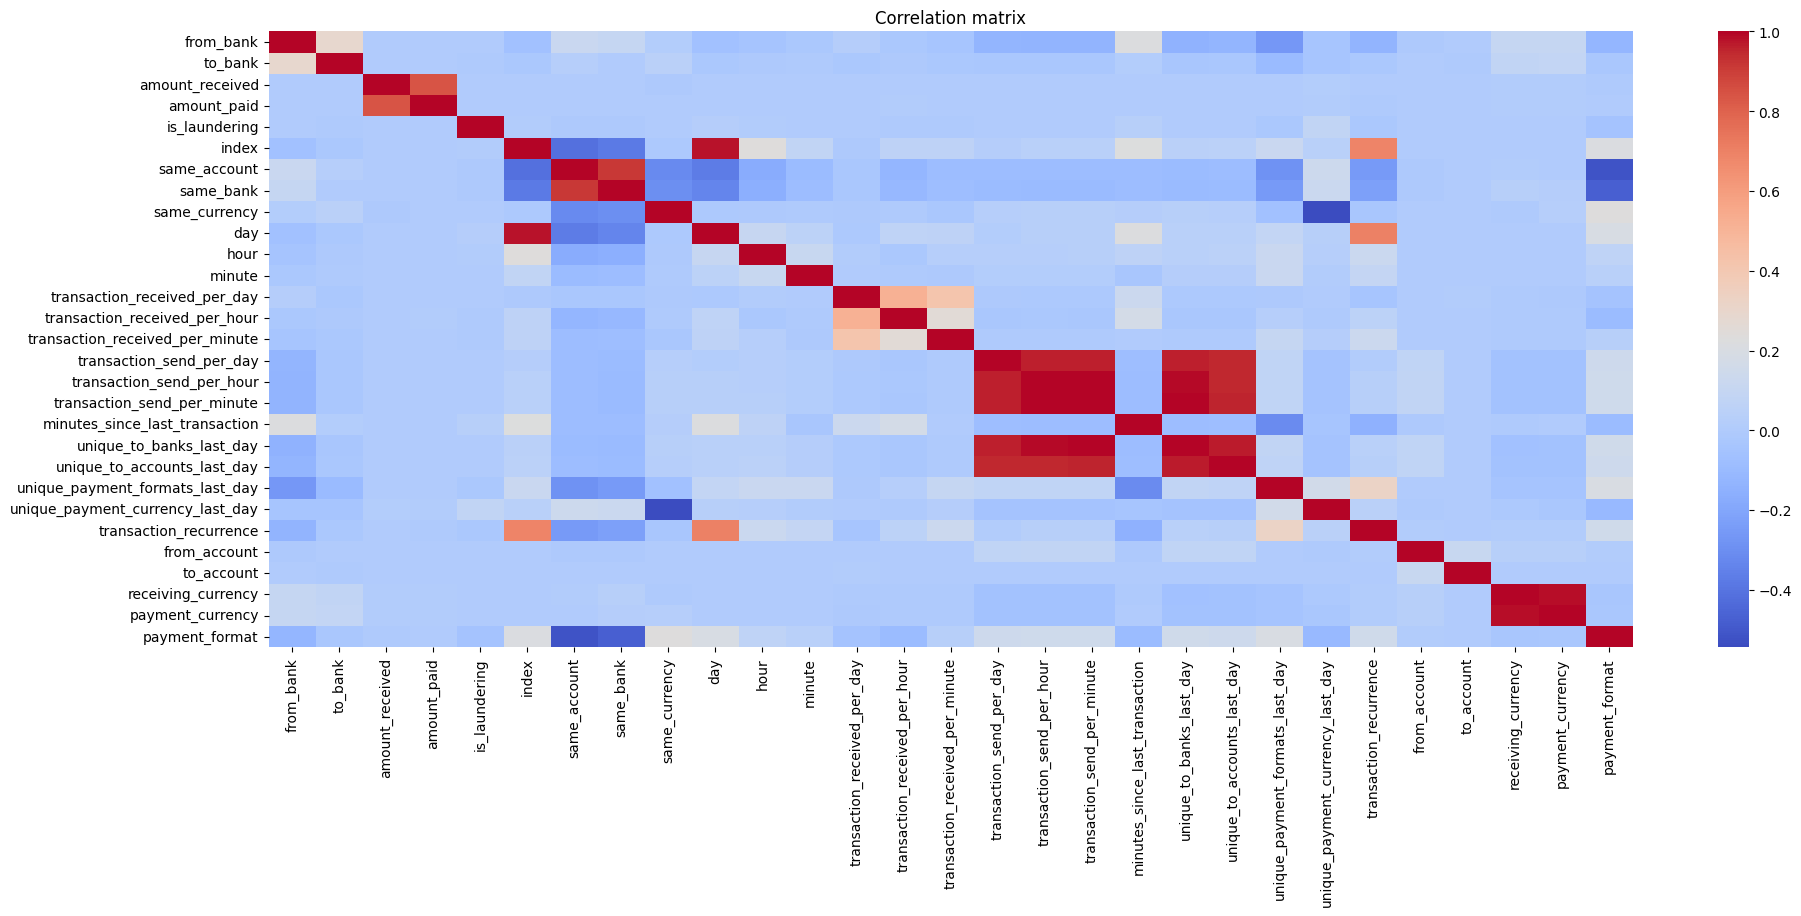

In [7]:
# Read the parquet file directly with pandas
df = pd.read_parquet('partial_results/df.parquet')


# Compute the correlation matrix
laundering_corr_matrix = df.corr()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(22, 8))
sns.heatmap(laundering_corr_matrix, cmap='coolwarm', annot=False, ax=ax)
ax.set_title('Correlation matrix')
plt.show()

La matrice di correlazione mostra come non ci siano forti correlazioni tra le etichette e le features prese in esame. Viceversa si può notare come ci siano features strettamente correlate tra di loro che potrebbero causare ridondanza nei dati oltre che aumentare il numero di features rendendo il modello più complesso e causare overfitting. Le forti correlazioni vengono però risolte in quanto viene utilizzato un modello di apprendimento random forest che va a campionare e selezionare diverse features per ogni albero.


